In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.autograd
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import torch.nn.functional as F

from torchsummary import summary

from mydataset import MyTrainDataset, my_dataset_worker_init_func

from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

D:\Anaconda3\envs\lgsvl\lib\site-packages\l5kit\dataset\select_agents.py:32: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


# 数据处理

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "E:/Downloads/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'CVAE', 'latent_dim': 128, 'history_step_size': 1, 'history_num_frames': 49, 'future_step_size': 1, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [154, 154], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 2}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 32, 'shuffle': False, 'num_workers': 0}, 'train_params': {'checkpoint_every_n_steps': 10000, 'epochs': 1, 'eval_every_n_steps': 10000}}


In [3]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
print(train_dataset)
print(train_dataset[0].keys())

train_dataset = MyTrainDataset(cfg, dm)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=train_cfg["shuffle"], 
    batch_size=train_cfg["batch_size"],
    num_workers=train_cfg["num_workers"],
    persistent_workers=True,
    worker_init_fn=my_dataset_worker_init_func
)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velociti

# 参数

In [4]:
# 基本参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
epochs = cfg["train_params"]["epochs"]
latent_dim = cfg["model_params"]["latent_dim"]  # LSTM 的单元个数
num_classes = 3 # 类数
encoder_length = cfg["model_params"]["history_num_frames"]
decoder_length = cfg["model_params"]["future_num_frames"]
num_encoder_tokens = 2
num_decoder_tokens = 2
z_dimension = 2

# 模型

In [5]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        # 定义编码器
        self.encoder = nn.LSTM(
            num_encoder_tokens, latent_dim, num_layers = 1, batch_first=True)
        self.encoder_mean1 = nn.Linear(latent_dim, 32)
        self.encoder_mean2 = nn.Linear(32, z_dimension)
        self.encoder_std1 = nn.Linear(latent_dim, 32)
        self.encoder_std2 = nn.Linear(32, z_dimension)
        self.decoder = nn.LSTM(z_dimension, latent_dim, num_layers = 1, batch_first=True)
        self.decoder_fc1 = nn.Linear(latent_dim, 32)
        self.decoder_fc2 = nn.Linear(32, num_decoder_tokens)

    def noise_reparameterize(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, data):
        inputs = torch.FloatTensor(data["history_positions"]).to(device)
        if inputs.dim()==2:
            inputs.resize_(1,inputs.size()[0],inputs.size()[1])
#         print(inputs.size())
        h0 = torch.autograd.Variable(torch.randn(
            1, inputs.size()[0], latent_dim)).to(device)
        c0 = torch.autograd.Variable(torch.randn(
            1, inputs.size()[0], latent_dim)).to(device)
        out1, _ = self.encoder(inputs, (h0, c0))
        mean1 = F.relu(self.encoder_mean1(out1), inplace=True)
        mean2 = F.relu(self.encoder_mean2(mean1), inplace=True)
        logstd1 = F.relu(self.encoder_std1(out1), inplace=True)
        logstd2 = F.relu(self.encoder_std2(logstd1), inplace=True)
        z = self.noise_reparameterize(mean2, logstd2)
        out2, _ = self.decoder(z)
        out2 = F.relu(self.decoder_fc1(out2), inplace=True)
        y_hat = F.relu(self.decoder_fc2(out2), inplace=True)
        return y_hat, mean2, logstd2


def loss_function(y_hat, data, mean, std):
    y_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    y_true = data["target_positions"].to(device)
    MSE = F.mse_loss(y_hat, y_true, reduction='none')
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    MSE = MSE * y_availabilities
    MSE = MSE.mean()
    # 因为var是标准差的自然对数，先求自然对数然后平方转换成方差
    var = torch.pow(torch.exp(std), 2)
    KLD = -0.5 * torch.mean(1+torch.log(var)-torch.pow(mean, 2)-var)
    return MSE+KLD


# 创建对象
cvae = CVAE().to(device)
# vae.load_state_dict(torch.load('./VAE_z2.pth'))
cvae_optimizer = torch.optim.Adam(cvae.parameters())

In [6]:
# print(len(train_dataloader))
# lossdata=[]
# for epoch in range(epochs):  # 进行多个epoch的训练
#     for i, data in enumerate(train_dataloader):
#         if i>=1000:
#             break
#         y_hat, mean, std = cvae(data)  # 输入
#         loss = loss_function(y_hat, data, mean, std)
#         cvae_optimizer.zero_grad()  # 在反向传播之前，先将梯度归0
#         loss.backward()  # 将误差反向传播
#         cvae_optimizer.step()  # 更新参数
#         lossdata.append(loss.item())
#         print('Epoch[{}/{}],cvae_loss:{:.6f} '.format(
#             epoch, epochs, loss.item(),
#         ))
# plt.plot(np.arange(len(lossdata)), lossdata, label="train loss")
# plt.legend()
# plt.show()

In [7]:
# ==== TRAIN LOOP
losses_avg = []
for epoch in range(epochs):  # 进行多个epoch的训练
    tr_it = iter(train_dataloader)
    progress_bar = tqdm(range(len(train_dataloader)//5),position=0)
    losses_train = []
    for _ in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        cvae.train() # 设置为训练模式
        torch.set_grad_enabled(True)
        y_hat, mean, std = cvae(data)  # 输入
        loss = loss_function(y_hat, data, mean, std)

        # Backward pass
        cvae_optimizer.zero_grad()
        loss.backward()
        cvae_optimizer.step()
        losses_train.append(loss.item())
        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    losses_avg.append(np.mean(losses_train))

loss: 14.836247444152832 loss(avg): 35.26675438367825: 100%|█████████████████████████| 697/697 [12:19<00:00,  1.08s/it]


# 结果

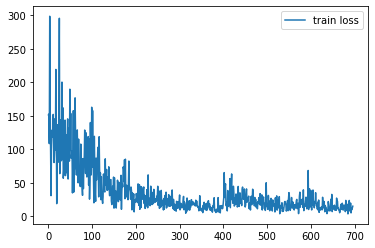

In [8]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

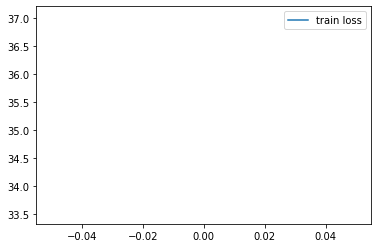

In [9]:
plt.plot(np.arange(len(losses_avg)), losses_avg, label="train loss")
plt.legend()
plt.show()

# 评估

In [10]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

copying: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.86it/s]
D:\Anaconda3\envs\lgsvl\lib\site-packages\l5kit\evaluation\extract_ground_truth.py:52: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|████████████████████████████████████████████████████████████████| 480/480 [00:02<00:00, 187.28it/s]


In [11]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=0,drop_last=False)
print(eval_dataset)
print(eval_dataset[0].keys())

# eval_dataset = MyTrainDataset(cfg, dm, agents_mask=eval_mask)
# eval_dataloader = DataLoader(
#     eval_dataset,
#     shuffle=eval_cfg["shuffle"], 
#     batch_size=eval_cfg["batch_size"],
#     num_workers=eval_cfg["num_workers"],
#     persistent_workers=True,
#     worker_init_fn=my_dataset_worker_init_func,
#     drop_last=True
# )

D:\Anaconda3\envs\lgsvl\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velociti

## 保存预测

In [12]:
# ==== EVAL LOOP
cvae.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader,position=0)

for data in progress_bar:
    y_hat, mean, std = cvae(data)
#     print(data)
    # convert agent coordinates into world offsets
    agents_coords = y_hat.cpu().numpy()
    world_from_agents = data['world_from_agent'].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.51s/it]


## 预测结果

In [13]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 1015.0342068503815
time_displace [1.46672079 1.70085512 1.83702951 1.87469213 1.91539255 1.93228489
 1.96243262 2.02556255 2.00643696 2.01816328 2.03292558 2.03638687
 2.10776089 2.20765373 2.31634551 2.43451747 2.4932101  2.57890079
 2.69471137 2.83486499 2.95870579 3.08187401 3.22703645 3.39802209
 3.54007634 3.69717355 3.81154217 3.92865411 4.02930574 4.06227311
 4.14753831 4.216624   4.29766677 4.36306918 4.4741005  4.56691366
 4.62780104 4.61590422 4.69028378 4.73001069 4.81549182 4.91247752
 4.94697359 5.06333543 5.07340363 5.03552617 5.12414528 5.28973879
 5.42581337 5.61719895]


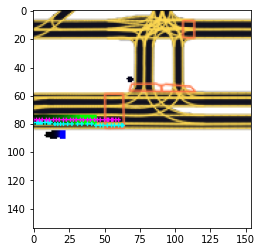

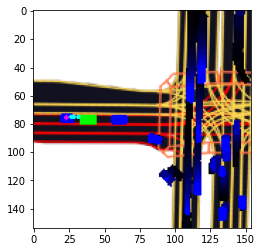

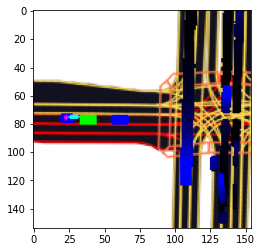

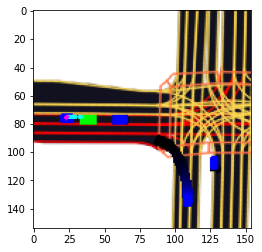

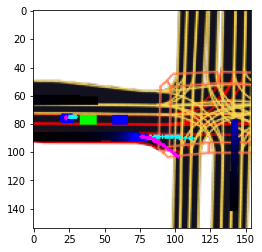

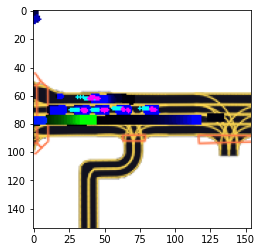

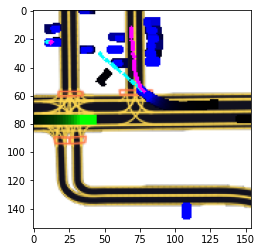

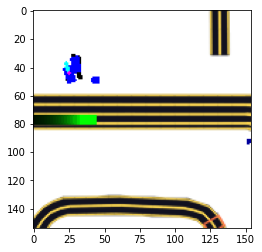

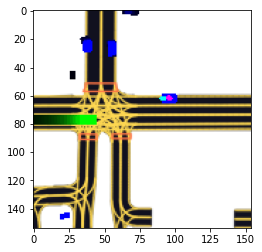

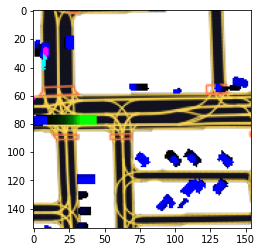

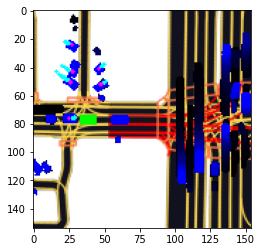

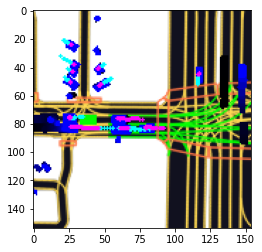

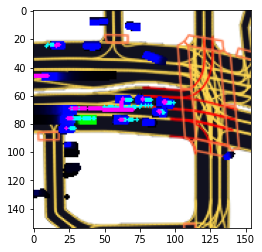

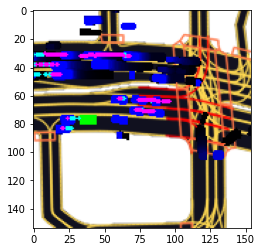

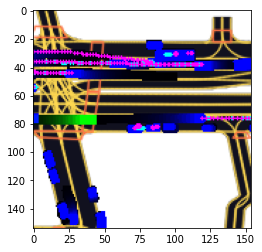

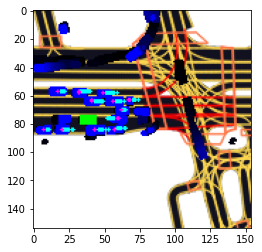

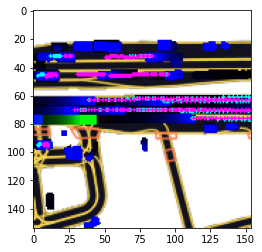

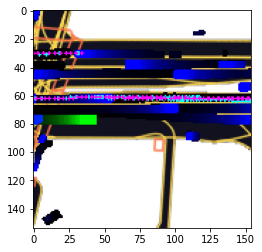

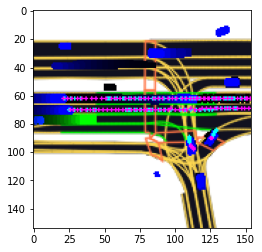

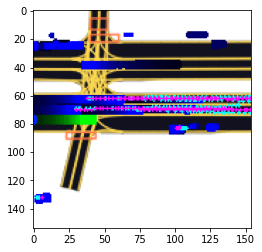

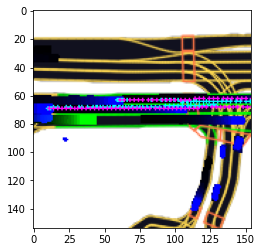

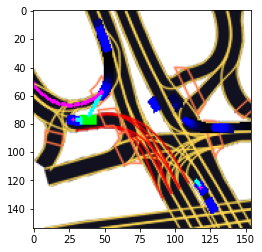

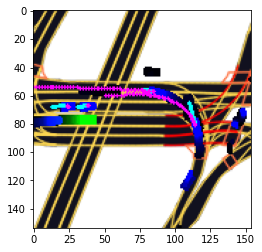

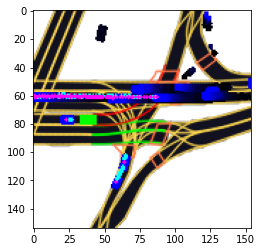

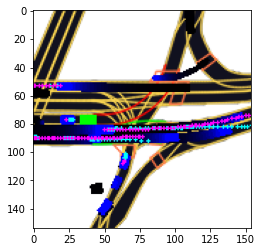

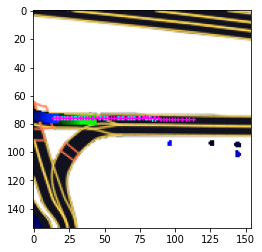

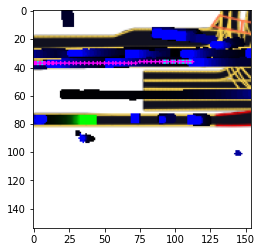

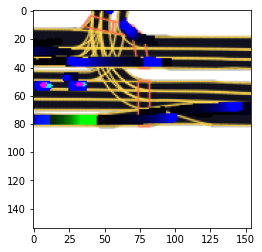

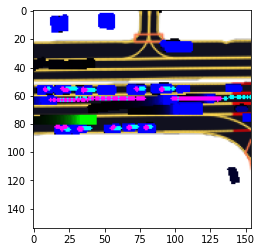

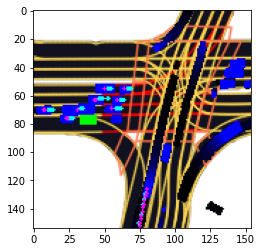

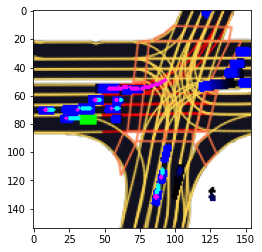

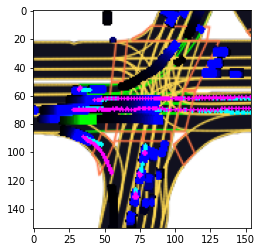

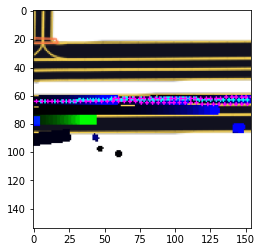

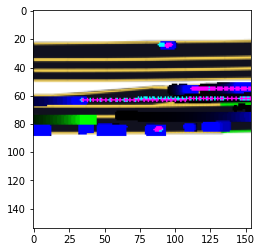

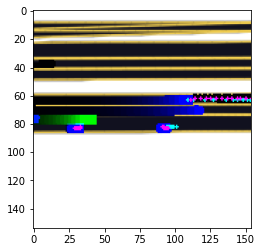

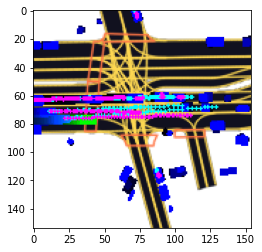

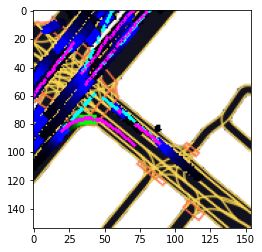

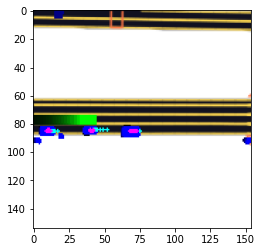

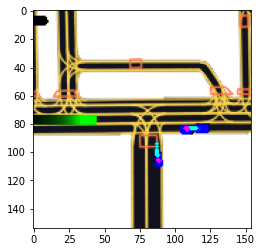

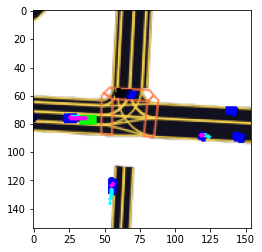

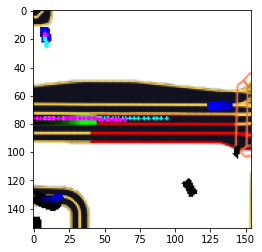

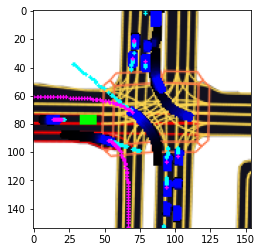

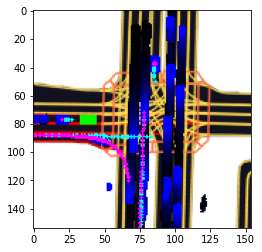

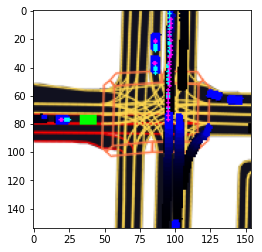

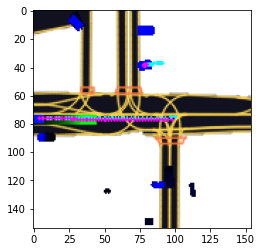

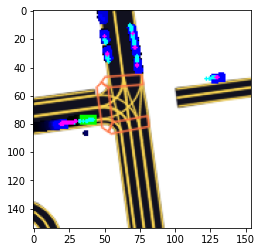

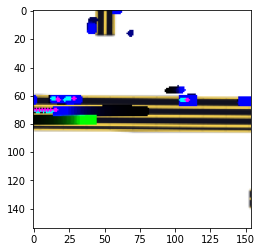

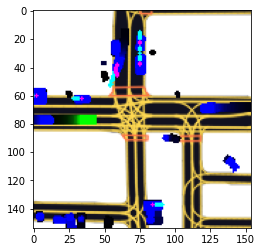

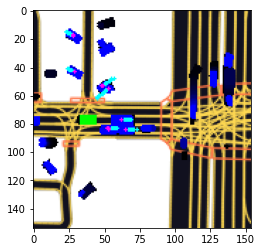

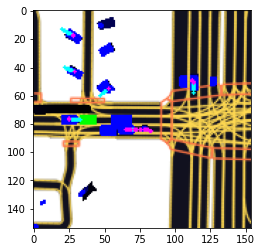

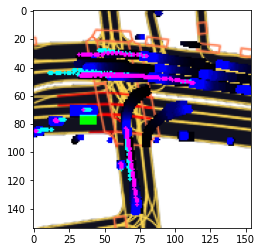

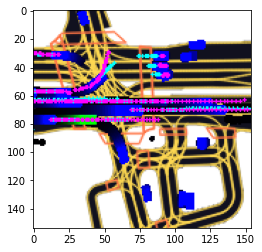

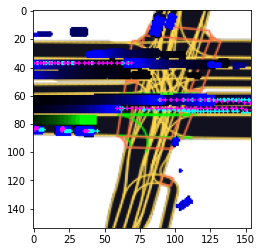

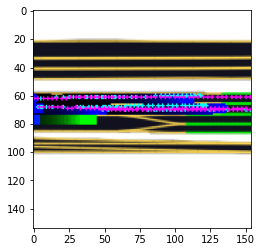

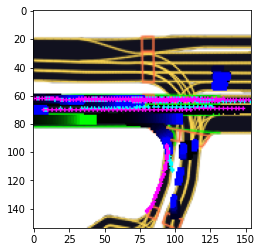

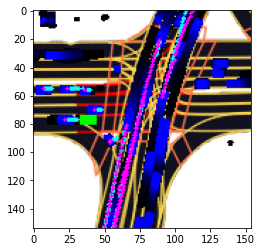

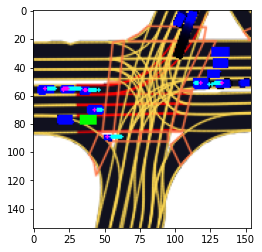

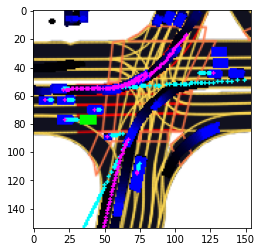

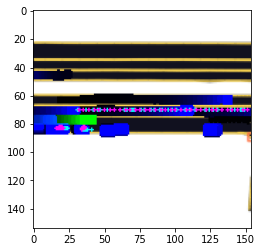

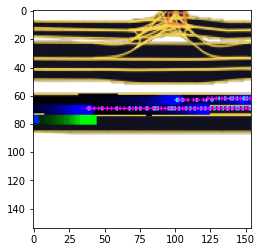

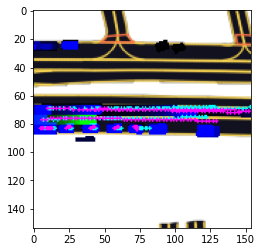

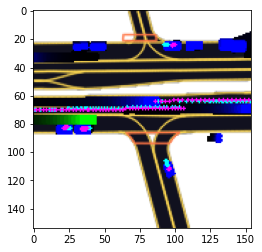

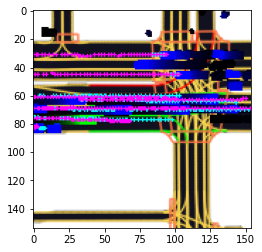

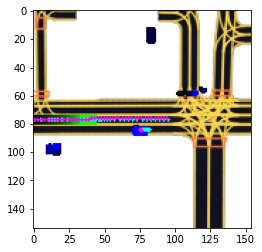

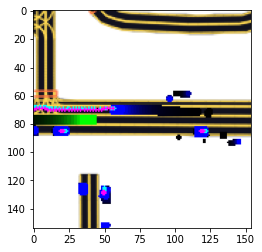

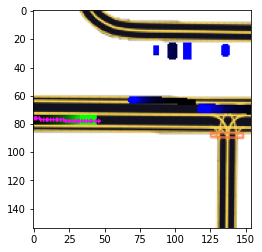

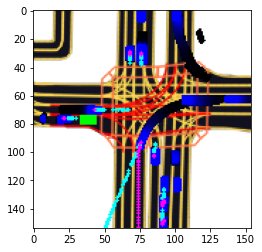

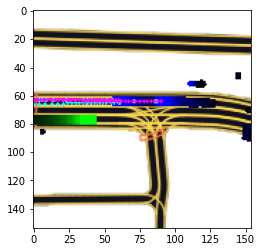

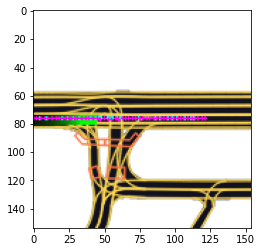

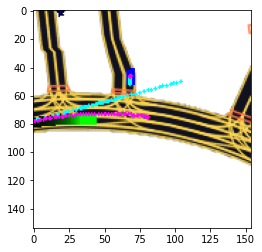

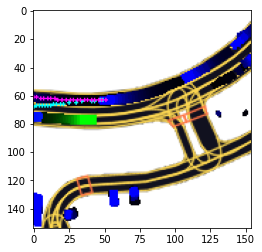

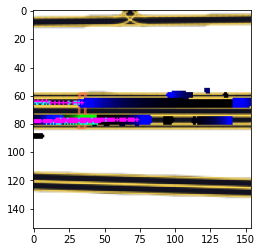

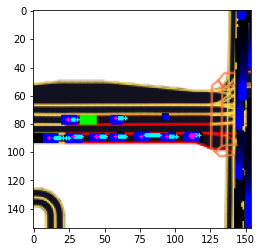

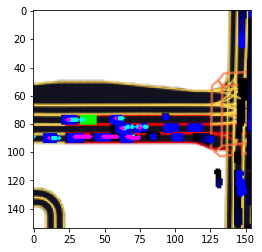

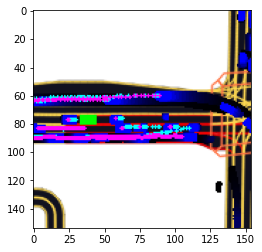

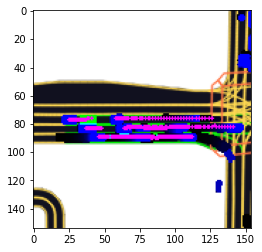

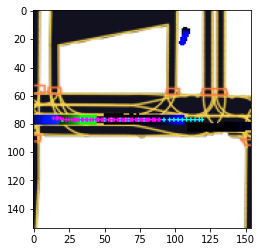

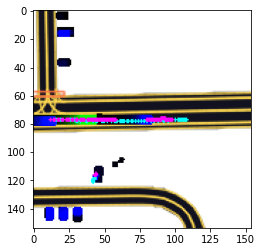

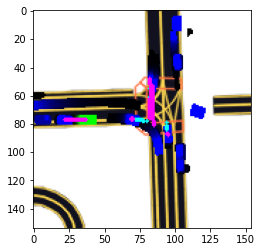

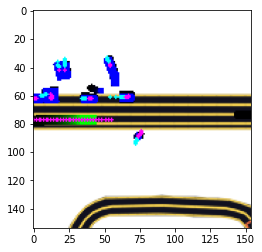

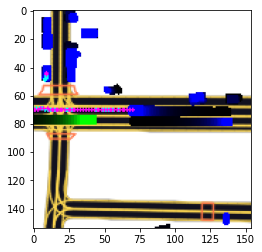

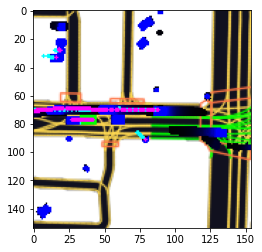

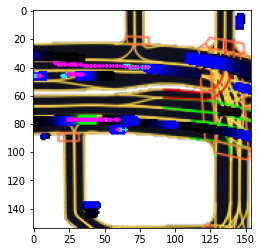

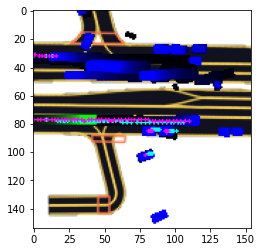

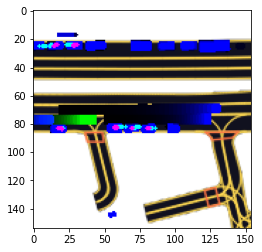

In [14]:
cvae.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]
        out_net = cvae(data_agent)
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.show()